<a href="https://colab.research.google.com/github/gawronn91/Fraud_detection/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

## 1.1 Explaining concept of Cross-Validation

Cross Validation is a resampling method, which uses different subsets of data to train and test the machine learning model.<br>
The proper approach in machine learning projects says to split data into train, test and validation datasets.<br>
<br>
When the training model is constructed like the one considered in this project, only a train set will be considered. 
And it has its own variance and irreducible error rate.<br>

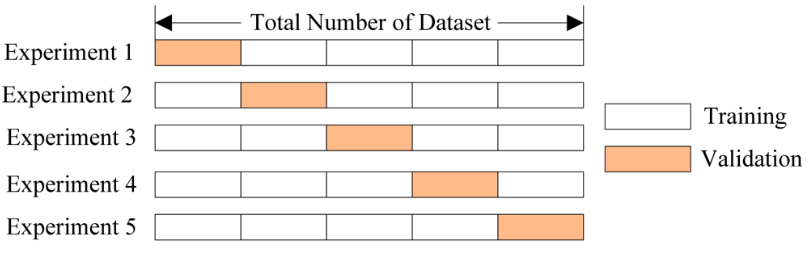

Cross Validation provides the ability to estimate model performance on unseen data not used while training. <br>
<br>
In this kernell, I will perform tests to choose the best Cross-Validation method for our dataset.
The considered methods are:
* k-Fold
* Group k-Fold
* LBO - Last Block Out

## 1.2 Importing Necessary Libraries

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec # to do the grid of plots
import seaborn as sns

#Dates
from datetime import datetime
from datetime import timedelta

# Math
import math

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, KFold, GroupKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_score, recall_score, fbeta_score, confusion_matrix, plot_confusion_matrix, precision_recall_curve, accuracy_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb

#Feature selection
from boruta import BorutaPy

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
sns.set_theme(style="white")

# 2. Data Loading

In [ ]:
train_df = pd.read_pickle('/Users/gawro/OneDrive/Pulpit/PJATK/Projekt_wlasny/2tygodnie_do_konca/train_nan(-999).pkl')

startdate = datetime.strptime('2017-11-30', '%Y-%m-%d')

timedelta = pd.to_timedelta(train_df['TransactionDT_old'], unit='s')
train_df['TransactionDTMonth'] = pd.to_datetime(startdate + timedelta,unit='s').dt.month

# In this case test data set will be the last month of transactions
test_df = train_df[train_df['TransactionDTMonth']==train_df['TransactionDTMonth'].max()].reset_index(drop=True)
train_df = train_df[train_df['TransactionDTMonth']<(train_df['TransactionDTMonth'].max())].reset_index(drop=True)

print('Shape of train dataset: ', train_df.shape)
print('Shape of test dataset: ', test_df.shape)

Shape of train dataset:  (453219, 525)
Shape of test dataset:  (137321, 525)


# 3. Cross-Validation models

## 3.1 Model parameters

To estimate best Cross-Validation method I will use LGB model with parameters as below:

In [ ]:
# Parameters:
n_splits = 3
seed = 42

# LGB Model parameters
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':20000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': seed,
                    'early_stopping_rounds':100, 
                }

rm_cols = ['TransactionID', 'TransactionDT', 'TransactionDT_old', 'isFraud', 'TransactionDTMonth'] # Columns to be removed

# Remove V columns (for faster training)
rm_cols += ['V'+str(i) for i in range(1,340)]

# Final features
features_columns = [col for col in list(train_df) if col not in rm_cols]

## Dataframe to compare results
results = pd.DataFrame(index=test_df.index)
results['isFraud'] = test_df['isFraud']

## 3.2 No validation

In the beginning, we may check the AUC score without any validation. <br>
As it is done on a full training dataset, it shall have better results than any Cross Validation method, because of the larger dataset.<br>
But it will have a positive influence on training and testing the actual model.

In [ ]:
# Creating a dataset
X,y = train_df[features_columns], train_df['isFraud']

# Test Data (what we need to predict)
Pred = test_df[features_columns]

# Iteration for several numbers of boosting rounds
for n_rounds in [500,1000,2500,5000]:
    print(n_rounds, 'boosting rounds')
    corrected_lgb_params = lgb_params.copy()
    corrected_lgb_params['n_estimators'] = n_rounds
    corrected_lgb_params['early_stopping_rounds'] = None

    train_data = lgb.Dataset(X, label=y)
    
    estimator = lgb.train(
                corrected_lgb_params,
                train_data
            )

    results['no_validation_'+str(n_rounds)] = estimator.predict(Pred)
    print('AUC score', roc_auc_score(results['isFraud'], results['no_validation_'+str(n_rounds)]))
    print('\n')

500 boosting rounds
AUC score 0.8931007383755779


1000 boosting rounds
AUC score 0.8992295367919593


2500 boosting rounds
AUC score 0.9015395660926108


5000 boosting rounds
AUC score 0.9004663024607642




## 3.3 k-Fold

In k-Fold Cross-Validation we are splitting dataset into k subsets, called folds. <br>
Because it is not actual training of the model, but choosing best CV method, we will chave only 3 folds. <br>
Training will be performed 3 times with every folds as validation set.

In [ ]:
# Declaring folds
folds = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Creating a dataset
X,y = train_df[features_columns], train_df['isFraud']

# Test Data
Pred = test_df[features_columns]
results['kfold'] = 0

for fold_, (train_index, val_index) in enumerate(folds.split(X, y)):
    print('\n')
    print('Fold:',fold_+1)
    train_x, train_y = X.iloc[train_index,:], y.iloc[train_index]    
    val_x, val_y = X.iloc[val_index,:], y.iloc[val_index]    
    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(val_x, label=val_y)  

    estimator = lgb.train(
            lgb_params,
            train_data,
            valid_sets = [train_data, valid_data],
            verbose_eval = 1000,
        )

    results['kfold'] = estimator.predict(Pred)
print('\n')
print('AUC score', roc_auc_score(results['isFraud'], results['kfold']))



Fold: 1
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999978	valid_1's auc: 0.97346
[2000]	training's auc: 1	valid_1's auc: 0.97471
Early stopping, best iteration is:
[2082]	training's auc: 1	valid_1's auc: 0.974788


Fold: 2
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999972	valid_1's auc: 0.97207
Early stopping, best iteration is:
[1604]	training's auc: 1	valid_1's auc: 0.973554


Fold: 3
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999975	valid_1's auc: 0.975089
[2000]	training's auc: 1	valid_1's auc: 0.976731
Early stopping, best iteration is:
[1979]	training's auc: 1	valid_1's auc: 0.976758


AUC score 0.8993208048103227


## 3.4 Group k-Fold

This approach is similar to the normal k-Fold algorithm, but instead of the random split, datapoints are separated into groups.<br>
In our case, those groups will be months of transactions.

In [ ]:
# Declaring folds
folds = GroupKFold(n_splits=n_splits)

## Dividing dataset for time blocks:
timedelta = pd.to_timedelta(train_df['TransactionDT_old'], unit='s')
train_df['groups'] = startdate + timedelta
train_df['groups'] = (train_df['groups'].dt.year-2017)*12 + train_df['groups'].dt.month 

# Creating a dataset
X,y = train_df[features_columns], train_df['isFraud']
split_groups = train_df['groups']

# Test Data 
Pred = test_df[features_columns]
results['groupkfold'] = 0

for fold_, (train_index, val_index) in enumerate(folds.split(X, y, groups=split_groups)):
    print('\n')
    print('Fold:',fold_+1)
    train_x, train_y = X.iloc[train_index,:], y[train_index]    
    val_x, val_y = X.iloc[val_index,:], y[val_index]    
    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(val_x, label=val_y)  

    estimator = lgb.train(
            lgb_params,
            train_data,
            valid_sets = [train_data, valid_data],
            verbose_eval = 1000,
        )

    results['groupkfold'] += estimator.predict(Pred)/n_splits
print('\n')
print('AUC score', roc_auc_score(results['isFraud'], results['groupkfold']))



Fold: 1
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999972	valid_1's auc: 0.943049
Early stopping, best iteration is:
[1080]	training's auc: 0.999986	valid_1's auc: 0.943202


Fold: 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[794]	training's auc: 0.999951	valid_1's auc: 0.93765


Fold: 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[756]	training's auc: 0.999911	valid_1's auc: 0.943678


AUC score 0.9008175207136098


## 3.5 LBO (last block out)

This approach is based on classic k-Fold Cross-Validation. <br>
It takes a validation dataset from the train table. So, in this case, we have 1 month of transactions in the test set, 1 month for validation, and the rest in the training dataset. <br>
So in other words it is Cross-Validation in Cross-Validation, but we use always the same validation set with the training set changing as in normal k-Fold. <br>
Note that some part of the data is not used in that approach (this set, which would be a validation dataset in normal k-Fold).

This approach helps to adjust LBG algorithm parameters, which can be used after in actual k-Fold approach.


## 3.5.1 Model which estimates best parameters for actual Cross Validation model

In [ ]:
# Lst month will be used as Validation dataset
main_train_set = train_df[train_df['TransactionDTMonth']<(train_df['TransactionDTMonth'].max())].reset_index(drop=True)
validation_set = train_df[train_df['TransactionDTMonth']==train_df['TransactionDTMonth'].max()].reset_index(drop=True)

# Declaring folds - k-Fold in this example
folds = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Creating a dataset
X,y = main_train_set[features_columns], main_train_set['isFraud']
X_val, y_val = validation_set[features_columns], validation_set['isFraud']

estimators_bestround = []
for fold_, (train_index, val_index) in enumerate(folds.split(X, y)):
    print('\n')
    print('Fold:',fold_+1)
    train_x, train_y = X.iloc[train_index,:], y[train_index]    
    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(X_val, label=y_val)  

    estimator = lgb.train(
            lgb_params,
            train_data,
            valid_sets = [train_data, valid_data],
            verbose_eval = 1000,
        )
    estimators_bestround.append(estimator.current_iteration())

## Now we have best round estimators in a list
corrected_lgb_params = lgb_params.copy()
corrected_lgb_params['n_estimators'] = int(np.mean(estimators_bestround))
corrected_lgb_params['early_stopping_rounds'] = None
print('\n')
print('Mean Best round:', corrected_lgb_params['n_estimators'])



Fold: 1
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999997	valid_1's auc: 0.937401
Early stopping, best iteration is:
[907]	training's auc: 0.99999	valid_1's auc: 0.937763


Fold: 2
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999997	valid_1's auc: 0.936083
Early stopping, best iteration is:
[972]	training's auc: 0.999996	valid_1's auc: 0.936202


Fold: 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[859]	training's auc: 0.999978	valid_1's auc: 0.938996


Mean Best round: 912


### 3.5.2 Actual LBO model:

In [ ]:
# Creating a dataset
X,y = train_df[features_columns], train_df['isFraud']

# Test Data
Pred = test_df[features_columns]
results['LBO'] = 0

for fold_, (train_index, val_idx) in enumerate(folds.split(X, y)):
    train_x, train_y = X.iloc[train_index,:], y[train_index]
    train_data = lgb.Dataset(train_x, label=train_y)

    estimator = lgb.train(
            corrected_lgb_params,
            train_data
        )
    
    results['LBO'] += estimator.predict(Pred)/n_splits

print('AUC score', roc_auc_score(results['isFraud'], results['LBO'])) 

AUC score 0.8999827306303678


# 4. Results

Now we can compare results collected among used Cross Validation methods:

In [ ]:
results_df = []
for current_strategy in list(results.iloc[:,1:]):
    auc_score = roc_auc_score(results['isFraud'], results[current_strategy])
    results_df.append([current_strategy, auc_score])

final_df = pd.DataFrame(results_df, columns=['CV Stategy', 'AUC Result'])
final_df.sort_values(by=['AUC Result'], ascending=False, inplace=True)

final_df

,CV Stategy,AUC Result
2,no_validation_2500,0.912276
1,no_validation_1000,0.911246
3,no_validation_5000,0.910441
5,groupkfold,0.909873
6,LBO,0.908813
4,kfold,0.906598
0,no_validation_500,0.903638


Basing on this table all Cross-Validation approaches had similar results, but <b>Group k-Fold</b> was the best and will be used for training actual model.<br>
Nevertheless, due to similar results, all of them may be used in the actual model.

Link for the next notebook: [FS](https://drive.google.com/file/d/1vPB3qOO_ZgsDNJkbP3gkobQT61IoH99r/view?usp=share_link)